In [2]:
library(ggplot2)
library(dplyr)

library(rsample)
library(recipes)

library(caret)

In [3]:
attrition <- read.csv("C:/Users/apf_temp_admin/Documents/Hands on Machine Learning/WA_Fn-UseC_-HR-Employee-Attrition.csv",
                     stringsAsFactors = T)
colnames(attrition)[1] <- "Age"

In [4]:
cats = vector()
for (i in 1:length(attrition)) {
    cats[i] = n_distinct(attrition[i])
}

In [5]:
df <- attrition[, -which(cats == 1)]

In [6]:
set.seed(123)
churn_split <- initial_split(df, prop = 0.7, strata = "Attrition")
churn_train <- training(churn_split)
churn_test <- testing(churn_split)
dim(churn_train) ; dim(churn_test)

[1] 1028   32

[1] 442  32

In [7]:
mnist <- dslabs::read_mnist()

In [8]:
names(mnist)

[1] "train" "test"

In [9]:
set.seed(123)
ames <- AmesHousing::make_ames()
index <- sample(1:dim(ames)[1], 0.7*dim(ames)[1])
ames_train <- ames[index,]
ames_test <- ames[-index,]
dim(ames_train) ; dim(ames_test)

[1] 2051   81

[1] 879  81

### KNN
- 각 관찰이 다른 관찰과의 "유사성"을 기반으로 예측되는 매우 간단한 알고리즘

### 유사성 측정

### 거리 측정

In [10]:
(two_houses <- ames_train[1:2, c("Gr_Liv_Area", "Year_Built")])

Gr_Liv_Area,Year_Built
<int>,<int>
1489,2006
1524,2000


### ```dist()```
- ```method``` = ```"euclidean"```, ```"maximum"```, ```"manhattan"```, ```"canberra"```, ```"binary"```, ```"minkowski"```

#### 유클리디안 거리

In [11]:
dist(two_houses, method = "euclidean")

         1
2 35.51056

#### 맨하탄 거리

In [12]:
dist(two_houses, method = "manhattan")

   1
2 41

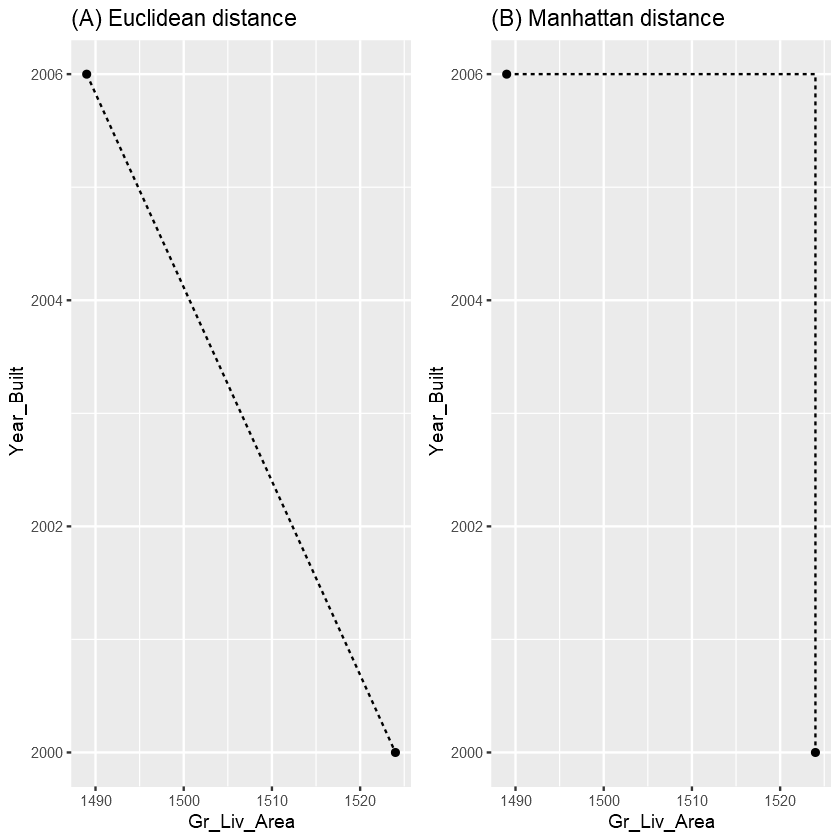

In [13]:
p1 <- ggplot(two_houses, aes(Gr_Liv_Area, Year_Built)) +
  geom_point() +
  geom_line(lty = "dashed") +
  ggtitle("(A) Euclidean distance")
  

p2 <- ggplot(two_houses, aes(Gr_Liv_Area, Year_Built)) +
  geom_point() +
  geom_step(lty = "dashed") +
  ggtitle("(B) Manhattan distance")

gridExtra::grid.arrange(p1, p2, nrow = 1)

### 전처리
- 유클리드 거리는 이상값에 민감, 또한 대부분의 거리 측정은 변수의 규모에 민감
- 가장 큰 값을 가진 예측 변수가 두 샘플 사이의 거리에 가장 큰 영향을 미침
- **척도가 다른 변수가 있는 데이터는 거리 측정에 편향이 발생**

In [14]:
home1 <- ames %>%
  mutate(id = row_number()) %>%
  select(Bedroom_AbvGr, Year_Built, id) %>%
  filter(Bedroom_AbvGr == 4 & Year_Built == 2008) %>%
  slice(1) %>%
  mutate(home = "home1") %>%
  select(home, everything())

home2 <- ames %>%
  mutate(id = row_number()) %>%
  select(Bedroom_AbvGr, Year_Built, id) %>%
  filter(Bedroom_AbvGr == 2 & Year_Built == 2008) %>%
  slice(1) %>%
  mutate(home = "home2") %>%
  select(home, everything())

home3 <- ames %>%
  mutate(id = row_number()) %>%
  select(Bedroom_AbvGr, Year_Built, id) %>%
  filter(Bedroom_AbvGr == 3 & Year_Built == 1998) %>%
  slice(1) %>%
  mutate(home = "home3") %>%
  select(home, everything())

In [15]:
home1 ; home2 ; home3

home,Bedroom_AbvGr,Year_Built,id
<chr>,<int>,<int>,<int>
home1,4,2008,423


home,Bedroom_AbvGr,Year_Built,id
<chr>,<int>,<int>,<int>
home2,2,2008,424


home,Bedroom_AbvGr,Year_Built,id
<chr>,<int>,<int>,<int>
home3,3,1998,6


#### Year_Built의 차이로 인하여 home1과 home2사이의 유클리드 거리보다, home1과 home3사이의 유클리드 거리가 더 크다

In [16]:
features <- c("Bedroom_AbvGr", "Year_Built")
dist(rbind(home1[,features], home2[,features]))
dist(rbind(home1[,features], home3[,features]))

  1
2 2

         1
2 10.04988

#### 표준화 실행

In [17]:
scaled_ames <- recipe(Sale_Price ~ ., ames_train) %>%
  step_center(all_numeric()) %>%
  step_scale(all_numeric()) %>%
  prep(ames, retain = TRUE) %>%
  bake(ames)

In [18]:
home1_std <- scaled_ames %>%
  mutate(id = row_number()) %>%
  filter(id == home1$id) %>%
  select(Bedroom_AbvGr, Year_Built, id) %>%
  mutate(home = "home1") %>%
  select(home, everything())

home2_std <- scaled_ames %>%
  mutate(id = row_number()) %>%
  filter(id == home2$id) %>%
  select(Bedroom_AbvGr, Year_Built, id) %>%
  mutate(home = "home2") %>%
  select(home, everything())

home3_std <- scaled_ames %>%
  mutate(id = row_number()) %>%
  filter(id == home3$id) %>%
  select(Bedroom_AbvGr, Year_Built, id) %>%
  mutate(home = "home3") %>%
  select(home, everything())

In [19]:
home1_std ; home2_std ; home3_std

home,Bedroom_AbvGr,Year_Built,id
<chr>,<dbl>,<dbl>,<int>
home1,1.384186,1.211547,423


home,Bedroom_AbvGr,Year_Built,id
<chr>,<dbl>,<dbl>,<int>
home2,-1.032058,1.211547,424


home,Bedroom_AbvGr,Year_Built,id
<chr>,<dbl>,<dbl>,<int>
home3,0.1760642,0.8809181,6


#### 표준화 이후 유클리드 거리는 비슷해짐

In [20]:
dist(rbind(home1_std[,features], home2_std[,features]))
dist(rbind(home1_std[,features], home3_std[,features]))

         1
2 2.416244

         1
2 1.252547

- 숫자 특징을 표준화하는 것 외에도 모든 범주 특징은 원-핫 인코딩되거나 다른 방법(예: 순서 인코딩)을 사용하여 인코딩되어 모든 범주 특징이 숫자로 표현되어야함
- KNN 방법은 유사한 샘플이 더 큰 크기와 거리 값의 가변성을 갖도록 하기 때문에 노이즈이 많은 예측 변수에 매우 민감
- 결과적으로 관련이 없고 노이즈가 있는 변수들을 제거하면 종종 상당한 개선으로 이어짐

### K 선택하기
- 일반적인 규칙은 없음
- 홀수로 설정하는 것이 가장 좋음 (동점을 피할 수 있음)

In [21]:
blueprint <- recipe(Attrition ~ ., data = churn_train) %>%
  step_nzv(all_nominal()) %>%
  step_integer(contains("Satisfaction")) %>%
  step_integer(WorkLifeBalance) %>%
  step_integer(JobInvolvement) %>%
  step_dummy(all_nominal(), -all_outcomes(), one_hot = TRUE) %>%
  step_center(all_numeric(), -all_outcomes()) %>%
  step_scale(all_numeric(), -all_outcomes())


- ```summaryFunction```옵션은 관측값과 예측값을 취하여 성능 측도를 추정하는 함수에서 사용된다. **twoClassSummary는 ROC 곡선 아래의 면적, 민감도 및 특이도와 같은 2-집단(class) 문제에 대한 측도를 계산한다.**
- ROC 곡선은 예측된 클래스 확률(자동으로 계산되지 않음)을 기반으로 하므로 다른 옵션이 필요하다. ```classProbs = TRUE``` 옵션은 이러한 계산을 포함하는 데 사용된다.

In [22]:
cv <- trainControl(
  method = "repeatedcv", 
  number = 10, 
  repeats = 5,
  classProbs = TRUE,                 
  summaryFunction = twoClassSummary
)

In [23]:
hyper_grid <- expand.grid(
  k = floor(seq(1, nrow(churn_train)/3, length.out = 20))
)

In [24]:
knn_grid <- train(
  blueprint, 
  data = churn_train, 
  method = "knn", 
  trControl = cv, 
  tuneGrid = hyper_grid,
  metric = "ROC"
)

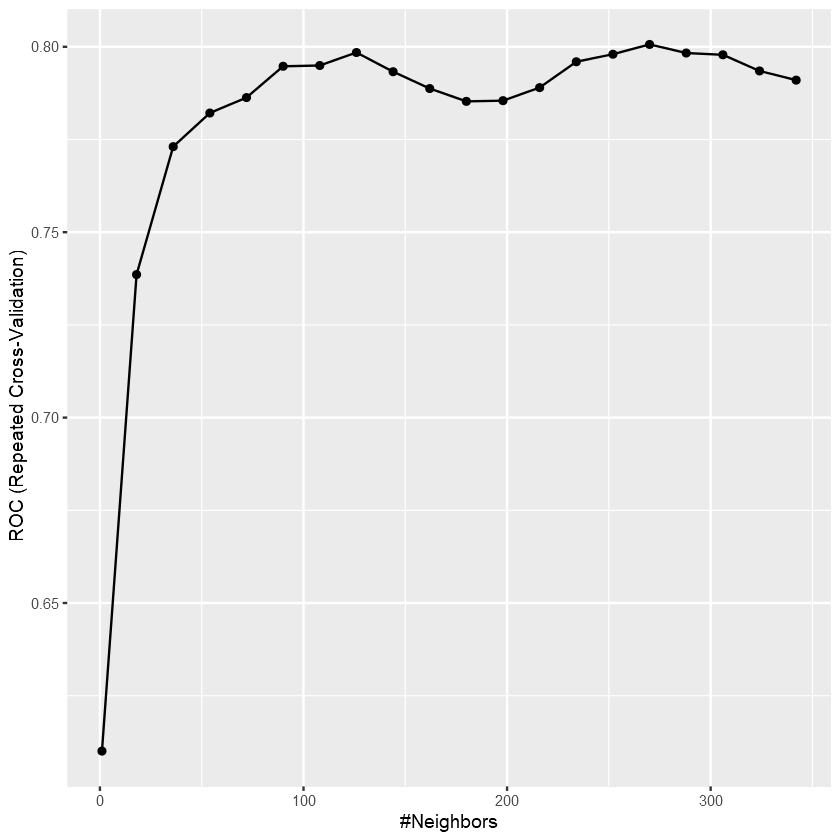

In [25]:
ggplot(knn_grid)

### MNIST 예제

- MNIST 데이터는 손으로 쓴 숫자(0~9) 이미지에서 픽셀의 명도(0~255)를 나타내는 784개의 변수로 구성
- KNN모델은 관련 없는 변수에의해 심각한 영향을 받을 수 있음 (0 또는 0에 가까운 분산을 가진 변수)

In [119]:
library(tidyr)
library(purrr)

In [46]:
str(mnist)

List of 2
 $ train:List of 2
  ..$ images: int [1:60000, 1:784] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ labels: int [1:60000] 5 0 4 1 9 2 1 3 1 4 ...
 $ test :List of 2
  ..$ images: int [1:10000, 1:784] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ labels: int [1:10000] 7 2 1 0 4 1 4 9 5 9 ...


In [90]:
dim(mnist$train$images)

[1] 60000   784

In [47]:
set.seed(123)
index <- sample(nrow(mnist$train$images), size = 10000)
mnist_x <- mnist$train$images[index, ]
mnist_y <- factor(mnist$train$labels[index])

In [54]:
dim(mnist_x) ; length(mnist_y)

[1] 10000   784

[1] 10000

#### 분산이 0인 변수의 개수가 약 120개
- KNN을 위해 제거필요

In [60]:
mnist_x %>% as.data.frame() %>% map_df(sd) %>%  gather(feature, sd) %>% head

feature,sd
<chr>,<dbl>
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0


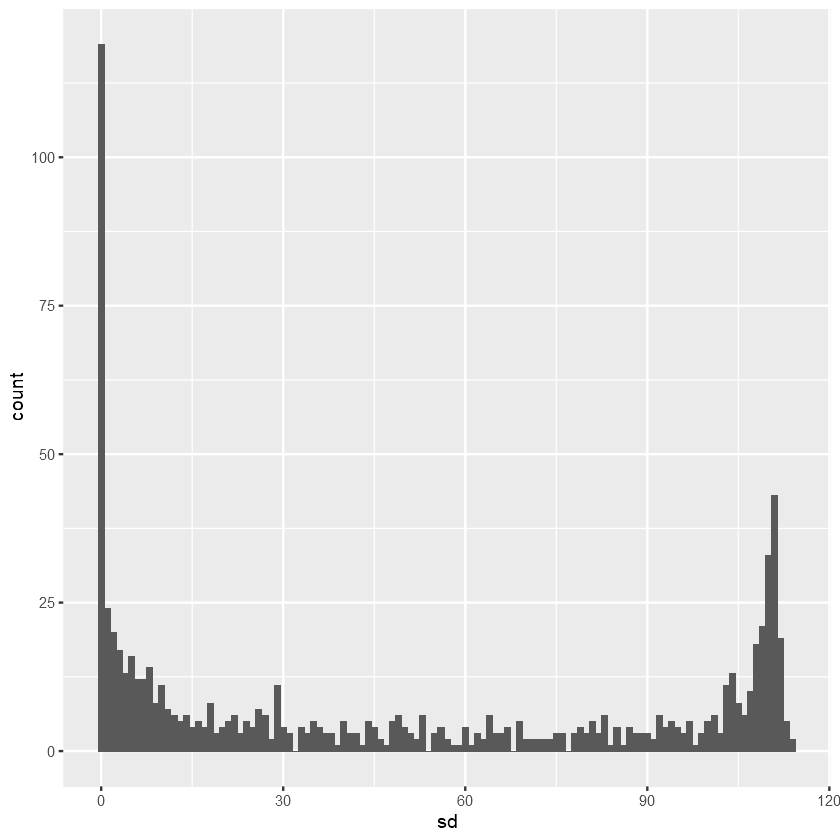

In [51]:
mnist_x %>%
  as.data.frame() %>%
  map_df(sd) %>%
  gather(feature, sd) %>%
  ggplot(aes(sd)) +
  geom_histogram(binwidth = 1)

#### 분산이 0에 근접한 변수 식별

In [103]:
nzv <- nearZeroVar(mnist_x)

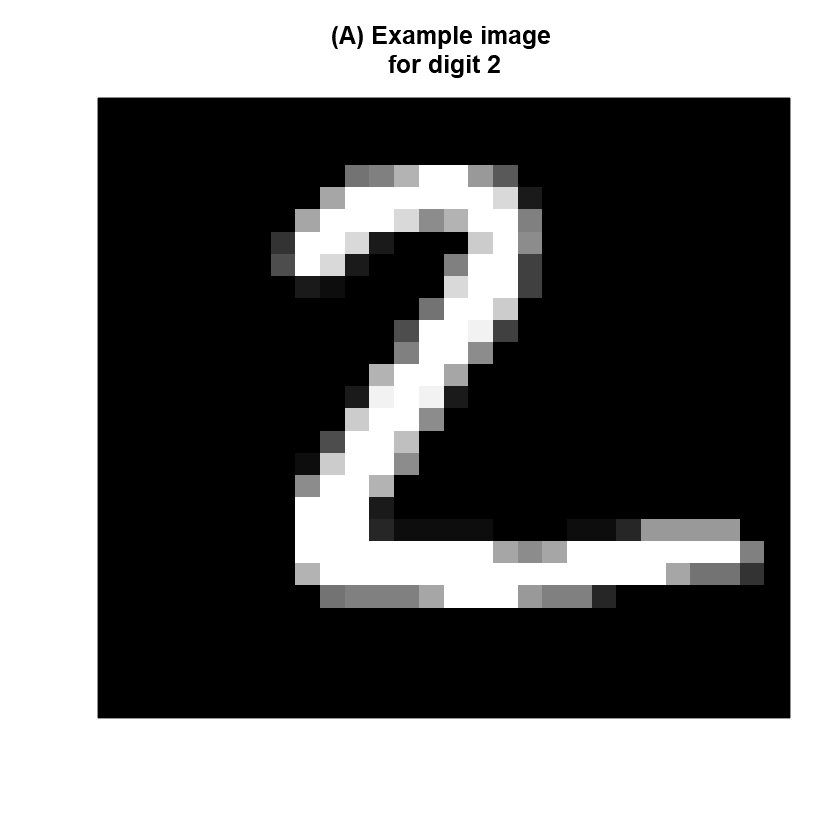

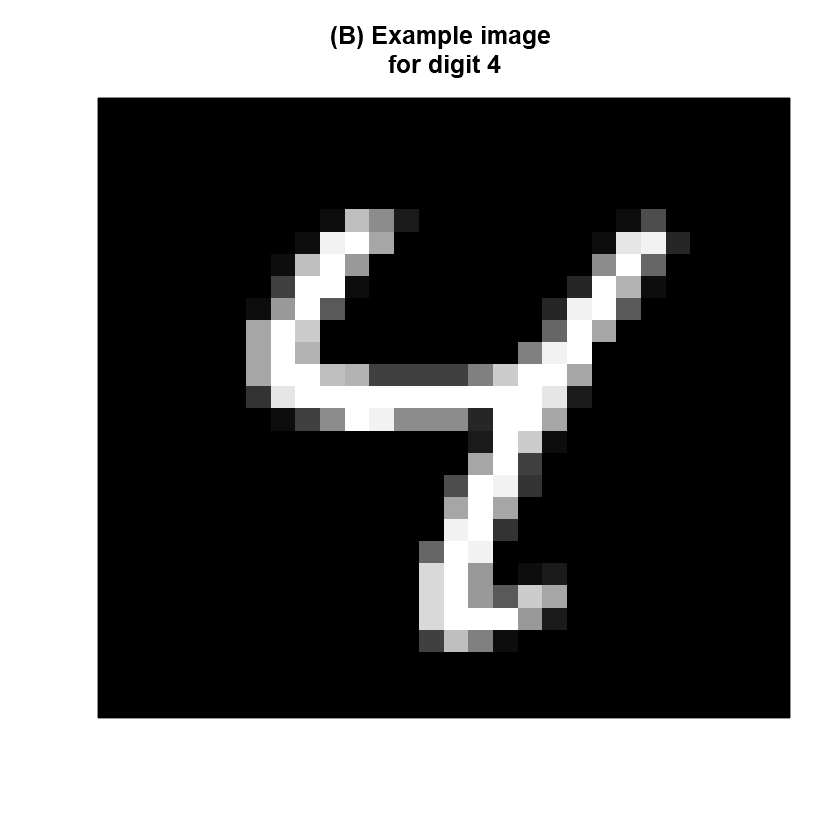

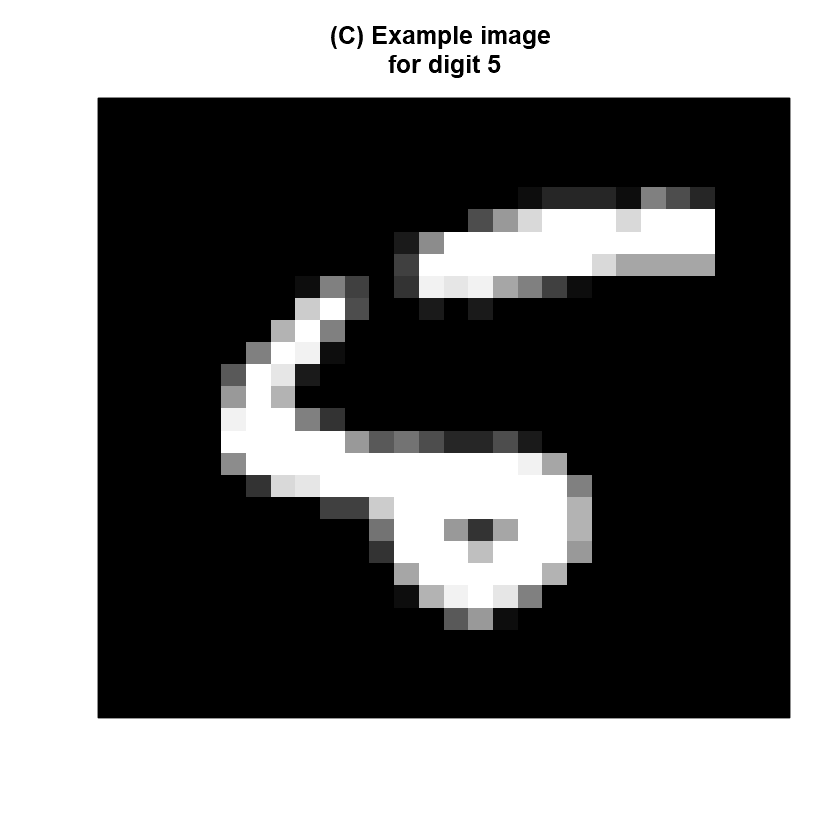

In [117]:
i <- 2
image(1:28, 1:28, matrix(mnist$test$images[i,], nrow=28)[ , 28:1], 
      col = gray(seq(0, 1, 0.05)), xlab = "", ylab="", 
      xaxt="n", yaxt="n", main = "(A) Example image \nfor digit 2")

i <- 7
image(1:28, 1:28, matrix(mnist$test$images[i,], nrow=28)[ , 28:1], 
      col = gray(seq(0, 1, 0.05)), xlab = "", ylab="", 
      xaxt="n", yaxt="n", main = "(B) Example image \nfor digit 4")

i <- 9
image(1:28, 1:28, matrix(mnist$test$images[i,], nrow=28)[ , 28:1], 
      col = gray(seq(0, 1, 0.05)), xlab = "", ylab="", 
      xaxt="n", yaxt="n", main = "(C) Example image \nfor digit 5")

In [79]:
colnames(mnist_x) <- paste0("V", 1:ncol(mnist_x))

#### 0에 가까운 분산을 가진 열을 제거

In [150]:
nzv <- nearZeroVar(mnist_x)
index <- setdiff(1:ncol(mnist_x), nzv)
mnist_x <- mnist_x[, index]

In [82]:
cv <- trainControl(
  method = "LGOCV", 
  p = 0.7,
  number = 1,
  savePredictions = TRUE
)

In [84]:
hyper_grid <- expand.grid(k = seq(3, 25, by = 2))
hyper_grid %>% head

,k
,<dbl>
1,3
2,5
3,7
4,9
5,11
6,13


In [85]:
knn_mnist <- train(
  mnist_x,
  mnist_y,
  method = "knn",
  tuneGrid = hyper_grid,
  preProc = c("center", "scale"),
  trControl = cv
)

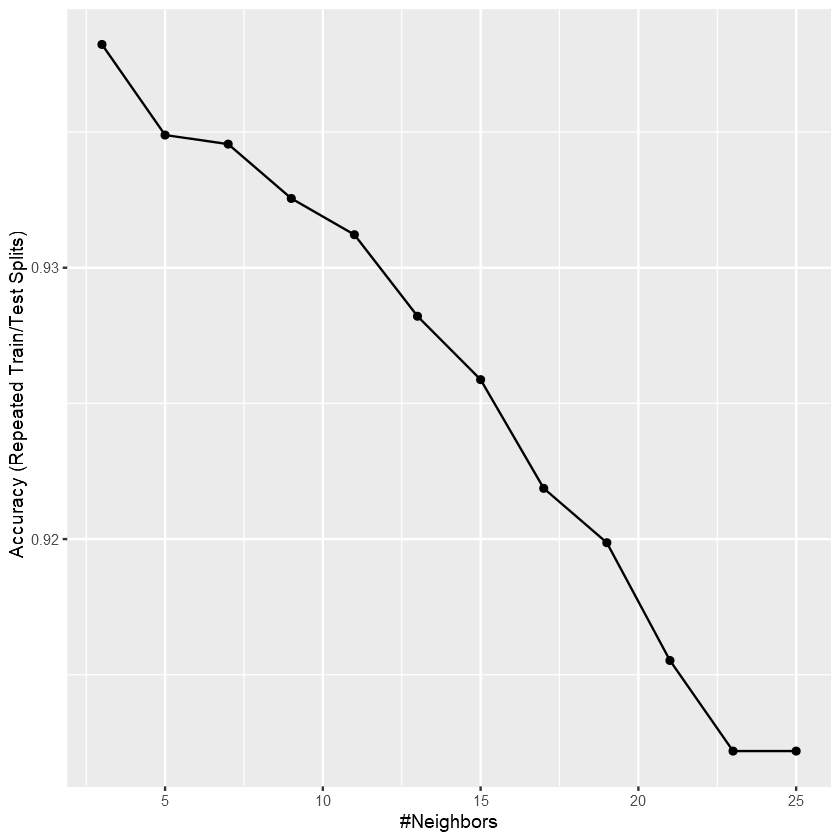

In [86]:
ggplot(knn_mnist)

### 혼동행령

In [109]:
cm <- confusionMatrix(knn_mnist$pred$pred, knn_mnist$pred$obs)

In [110]:
attributes(cm)

$names
[1] "positive" "table"    "overall"  "byClass"  "mode"     "dots"    

$class
[1] "confusionMatrix"

In [111]:
cm$byClass

,Sensitivity,Specificity,Pos Pred Value,Neg Pred Value,Precision,Recall,F1,Prevalence,Detection Rate,Detection Prevalence,Balanced Accuracy
Class: 0,0.9641638,0.9962374,0.9652620,0.9961145,0.9652620,0.9641638,0.9647126,0.09782972,0.09432387,0.09771842,0.9802006
Class: 1,0.9916667,0.9841210,0.8920540,0.9988808,0.8920540,0.9916667,0.9392265,0.11686144,0.11588759,0.12991096,0.9878938
Class: 2,0.9155666,0.9955114,0.9582614,0.9905440,0.9582614,0.9155666,0.9364276,0.10116861,0.09262660,0.09666110,0.9555390
Class: 3,0.9163952,0.9920325,0.9292596,0.9904665,0.9292596,0.9163952,0.9227826,0.10250417,0.09393434,0.10108514,0.9542139
Class: 4,0.8698630,0.9960538,0.9596977,0.9860823,0.9596977,0.8698630,0.9125749,0.09749583,0.08480801,0.08836950,0.9329584
Class: 5,0.9151404,0.9914891,0.9151404,0.9914891,0.9151404,0.9151404,0.9151404,0.09115192,0.08341681,0.09115192,0.9533148
Class: 6,0.9795322,0.9888684,0.9024784,0.9978280,0.9024784,0.9795322,0.9394279,0.09515860,0.09321091,0.10328325,0.9842003
Class: 7,0.9326520,0.9896962,0.9149100,0.9919813,0.9149100,0.9326520,0.9236958,0.10617696,0.09902615,0.10823595,0.9611741
Class: 8,0.8224382,0.9978798,0.9758910,0.9817704,0.9758910,0.8224382,0.8926174,0.09449082,0.07771285,0.07963272,0.9101590
Class: 9,0.9329897,0.9852687,0.8720557,0.9927338,0.8720557,0.9329897,0.9014942,0.09716194,0.09065109,0.10395103,0.9591292


### 변수 중요도

In [133]:
vi <- varImp(knn_mnist)
vi

ROC curve variable importance

  variables are sorted by maximum importance across the classes
  only 20 most important variables shown (out of 249)

         X0     X1     X2     X3     X4     X5     X6     X7     X8    X9
V435 100.00 100.00 100.00 100.00 100.00 100.00 100.00 100.00 100.00 80.56
V407  99.42  99.42  99.42  99.42  99.42  99.42  99.42  99.42  99.42 75.21
V463  97.88  97.88  97.88  97.88  97.88  97.88  97.88  97.88  97.88 83.27
V379  97.38  97.38  97.38  97.38  97.38  97.38  97.38  97.38  97.38 86.56
V434  95.87  95.87  95.87  95.87  95.87  95.87  96.66  95.87  95.87 76.20
V380  96.10  96.10  96.10  96.10  96.10  96.10  96.10  96.10  96.10 88.04
V462  95.56  95.56  95.56  95.56  95.56  95.56  95.56  95.56  95.56 83.38
V408  95.37  95.37  95.37  95.37  95.37  95.37  95.37  95.37  95.37 75.05
V352  93.55  93.55  93.55  93.55  93.55  93.55  93.55  93.55  93.55 87.13
V490  93.07  93.07  93.07  93.07  93.07  93.07  93.07  93.07  93.07 81.88
V406  92.90  92.90  92.90  92.90  92

In [124]:
library(tibble)
library(stringr)

#### 변수별 중앙값 

In [151]:
imp <- vi$importance %>%
  rownames_to_column(var = "feature") %>%
  gather(response, imp, -feature) %>%
  group_by(feature) %>%
  summarize(imp = median(imp))

imp %>% head

feature,imp
<chr>,<dbl>
V153,36.53080
V154,30.90408
V155,28.74736
V156,33.49078
V157,34.60262
V158,33.11361


In [152]:
edges <- tibble(
  feature = paste0("V", nzv),
  imp = 0
)
edges %>% head

feature,imp
<chr>,<dbl>
V,0


In [153]:
rbind(imp, edges) %>% head

feature,imp
<chr>,<dbl>
V153,36.53080
V154,30.90408
V155,28.74736
V156,33.49078
V157,34.60262
V158,33.11361


In [154]:
# Combine and plot
imp <- rbind(imp, edges) %>%
  mutate(ID  = as.numeric(str_extract(feature, "\\d+"))) %>%
  arrange(ID)

feature,imp,ID
<chr>,<dbl>,<dbl>
V153,36.53080,153
V154,30.90408,154
V155,28.74736,155
V156,33.49078,156
V157,34.60262,157
V158,33.11361,158


Warning message in matrix(imp$imp, 28, 28):
"data length [250] is not a sub-multiple or multiple of the number of rows [28]"


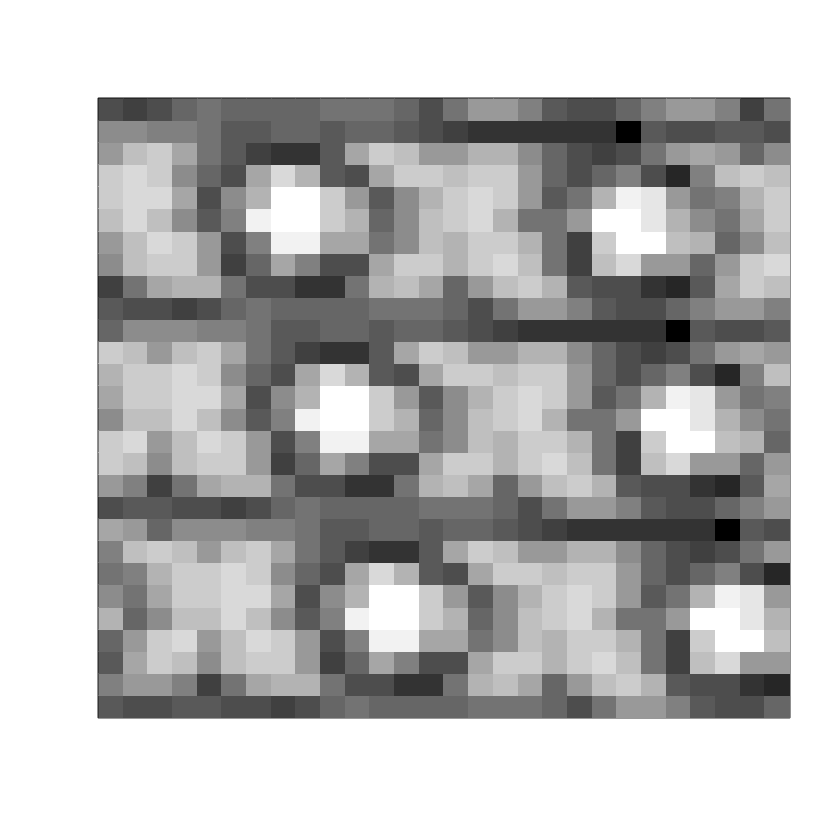

In [156]:
image(matrix(imp$imp, 28, 28), col = gray(seq(0, 1, 0.05)), 
      xaxt="n", yaxt="n")

### 정분류, 오분류
- 정분류 4개와, 오분류 4개를 추출

In [163]:
set.seed(9)
good <- knn_mnist$pred %>%
  filter(pred == obs) %>%
  sample_n(4)

set.seed(9)
bad <- knn_mnist$pred %>%
  filter(pred != obs) %>%
  sample_n(4)

combine <- bind_rows(good, bad)
dim(combine) ; head(combine)

[1] 8 5

,pred,obs,rowIndex,k,Resample
,<fct>,<fct>,<int>,<dbl>,<chr>
1,7,7,5685,3,Resample1
2,4,4,603,13,Resample1
3,1,1,1403,9,Resample1
4,2,2,6923,19,Resample1
5,1,6,3527,23,Resample1
6,2,1,6958,17,Resample1


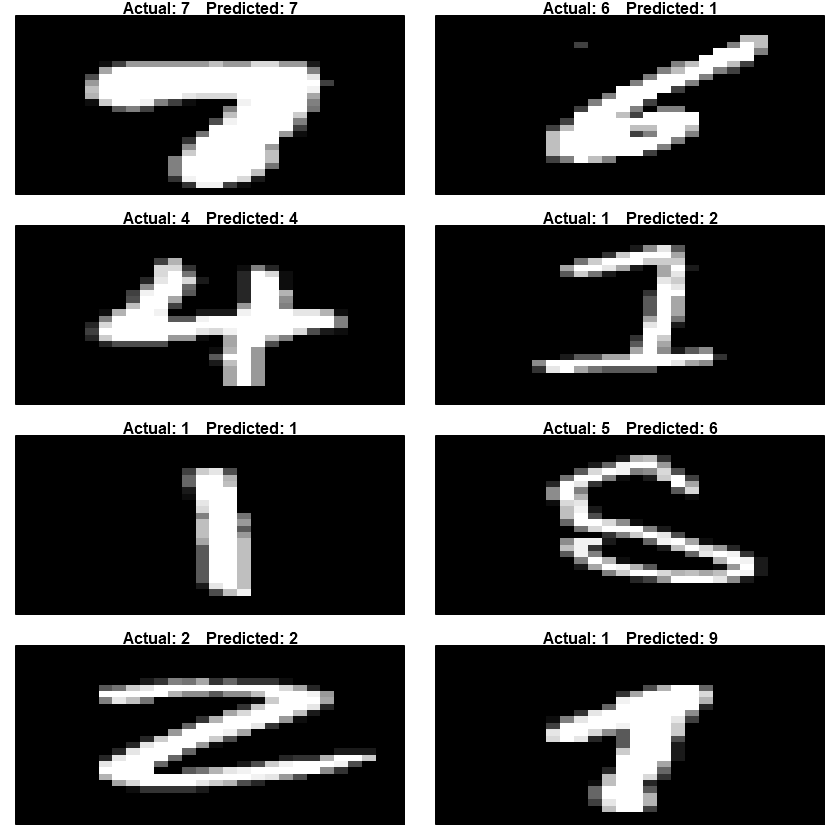

In [157]:
set.seed(123)
index <- sample(nrow(mnist$train$images), 10000)
X <- mnist$train$images[index,]

par(mfrow = c(4, 2), mar=c(1, 1, 1, 1))
layout(matrix(seq_len(nrow(combine)), 4, 2, byrow = FALSE))

for(i in seq_len(nrow(combine))) {
  image(matrix(X[combine$rowIndex[i],], 28, 28)[, 28:1], 
        col = gray(seq(0, 1, 0.05)),
        main = paste("Actual:", combine$obs[i], "  ", 
                     "Predicted:", combine$pred[i]),
        xaxt="n", yaxt="n") 
}